# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed-celeba-small.zip
# From https://stackoverflow.com/questions/3451111/unzipping-files-in-python/3451150 
#import zipfile
#zip = zipfile.ZipFile('processed-celeba-small.zip')
#zip.extractall()

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    num_workers = 0
    transform = transforms.Compose([
        transforms.CenterCrop(img_size),
        transforms.ToTensor()
    ])
    
    train_data = data_dir
    
    train_loader = datasets.ImageFolder(train_data, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_loader, batch_size=batch_size, shuffle=True)
    return train_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 64
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

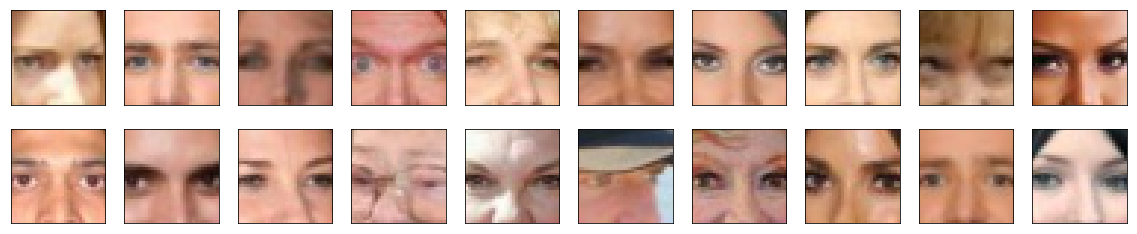

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min_value, max_value = feature_range
    x = x * (max_value - min_value) + min_value
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9765)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layer = []
    conv2d_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    layer.append(conv2d_layer)

    if batch_norm:
        layer.append(nn.BatchNorm2d(out_channels))
     
    return nn.Sequential(*layer)

def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layer = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    layer.append(transpose_conv_layer)
    
    if batch_norm:
        layer.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layer)

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        # 1st layer (input=32x32); no batch_norm
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        # 2nd layer (output=16X16)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 3rd layer
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        # hidden layers as well as leaky relu
        output = F.leaky_relu(self.conv1(x), 0.2)
        output = F.leaky_relu(self.conv2(output), 0.2)
        output = F.leaky_relu(self.conv3(output), 0.2)
        
        # flatten 
        output = output.view(-1, self.conv_dim*4*4*4)
        
        # fianl layer
        output = self.fc(output)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose the conv layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        output = self.fc(x)
        output = output.view(-1, self.conv_dim*4, 4, 4)
        # (batch_size, depth, 4, 4)
        
        # hiddden, transpose cov2d layers plus relu
        output = F.relu(self.t_conv1(output))
        output = F.relu(self.t_conv2(output))
        
        # final layer and hyperbolic tangent
        output = self.t_conv3(output)
        output = F.tanh(output)
        return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

C:\Users\madis\Anaconda3\lib\site-packages\torch\nn\functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [12]:
from torch.nn import init
def weights_init_normal(m, init_type='normal', init_gain=0.02):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    def init_func(m):
        classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    # From https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
                if init_type == 'normal':
                    init.normal_(m.weight.data, 0.0, init_gain)
                elif init_type == 'xavier':
                    init.xavier_normal_(m.weight.data, gain=init_gain)
                elif init_type == 'kaiming':
                    init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
                elif init_type == 'orthogonal':
                    init.orthogonal_(m.weight.data, gain=init_gain)
                else:
                    raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
                if hasattr(m, 'bias') and m.bias is not None:
                    init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
                init.normal_(m.weight.data, 1.0, init_gain)
                init.constant_(m.bias.data, 0.0)
    print('initialize network with %s' % init_type)
    m.apply(init_func) 

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [14]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32 
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, k

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [16]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    if(smooth):
        labels = torch.ones(batch_size)*0.9
        # If smooth is true, both smooth and labels are equal to 0.9
    else:
        labels = torch.ones(batch_size)
        # Else, labels are equal to one (1)
    if(train_on_gpu):
        labels = labels.cuda()
        # Move to GPU, assuming it is available
    criterion = nn.BCEWithLogitsLoss()
    # Selected as the result of this function having ~both~ signmoid and binary cross entory loss in just one (1) function
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    # Sets labels to a series of zeros (e.g. 0, 0, 0, .... 0)
    if(train_on_gpu):
        labels = labels.cuda()
        # Move to GPU, assuming it is available
    criterion = nn.BCEWithLogitsLoss()
    # Selected as the result of this function having ~both~ signmoid and binary cross entory loss in just one (1) function
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [17]:
import torch.optim as optim

# my paras
lr = 0.0002
beta1=0.5
beta2=0.999 

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [22]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            if (train_on_gpu):
                real_images = real_images.cuda()
            
            fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
            fixed_z = torch.from_numpy(fixed_z).float()
            
            if (train_on_gpu):
                fixed_z = fixed_z.cuda()
            
            fakes_d = G(fixed_z)
            
            D_real = D(real_images)
            D_fakes = D(fakes_d)
            d_loss = real_loss(D_real, smooth=True) + fake_loss(D_fakes)
            d_loss.backward()
            d_optimizer.step()
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
            fixed_z = torch.from_numpy(fixed_z).float()
            
            if (train_on_gpu):
                fixed_z = fixed_z.cuda()
                
            fakes_g = G(fixed_z)
            fakes = D(fakes_g)
            g_loss = real_loss(fakes, smooth=True)
            # Flips the labels
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [23]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 0.7253 | g_loss: 1.5249
Epoch [    1/   50] | d_loss: 0.3991 | g_loss: 3.4890
Epoch [    1/   50] | d_loss: 0.3590 | g_loss: 4.3546
Epoch [    1/   50] | d_loss: 0.4680 | g_loss: 4.4395
Epoch [    1/   50] | d_loss: 0.4999 | g_loss: 2.2407
Epoch [    1/   50] | d_loss: 0.4901 | g_loss: 3.1372
Epoch [    1/   50] | d_loss: 1.0789 | g_loss: 1.3458
Epoch [    1/   50] | d_loss: 0.5322 | g_loss: 2.6360
Epoch [    1/   50] | d_loss: 0.5828 | g_loss: 2.3408
Epoch [    1/   50] | d_loss: 1.1963 | g_loss: 3.7654
Epoch [    1/   50] | d_loss: 0.6421 | g_loss: 3.0272
Epoch [    1/   50] | d_loss: 0.7095 | g_loss: 1.7524
Epoch [    1/   50] | d_loss: 0.7674 | g_loss: 1.8443
Epoch [    1/   50] | d_loss: 0.8423 | g_loss: 1.5662
Epoch [    1/   50] | d_loss: 0.6062 | g_loss: 1.7921
Epoch [    1/   50] | d_loss: 0.8596 | g_loss: 1.5350
Epoch [    1/   50] | d_loss: 0.9894 | g_loss: 2.5113
Epoch [    1/   50] | d_loss: 0.8875 | g_loss: 1.1030
Epoch [    1/   50] | d_loss

Epoch [    6/   50] | d_loss: 0.4631 | g_loss: 3.4808
Epoch [    6/   50] | d_loss: 0.5181 | g_loss: 2.6718
Epoch [    6/   50] | d_loss: 0.7390 | g_loss: 2.0571
Epoch [    6/   50] | d_loss: 1.1740 | g_loss: 3.3149
Epoch [    6/   50] | d_loss: 1.0266 | g_loss: 3.2173
Epoch [    6/   50] | d_loss: 0.5733 | g_loss: 3.2856
Epoch [    6/   50] | d_loss: 0.4234 | g_loss: 2.4128
Epoch [    6/   50] | d_loss: 1.6844 | g_loss: 1.3065
Epoch [    6/   50] | d_loss: 1.1092 | g_loss: 1.0901
Epoch [    6/   50] | d_loss: 0.7992 | g_loss: 2.2392
Epoch [    6/   50] | d_loss: 0.4649 | g_loss: 3.0259
Epoch [    6/   50] | d_loss: 0.5181 | g_loss: 1.4508
Epoch [    6/   50] | d_loss: 0.5082 | g_loss: 1.8345
Epoch [    6/   50] | d_loss: 0.4914 | g_loss: 3.5091
Epoch [    6/   50] | d_loss: 0.5372 | g_loss: 2.1523
Epoch [    6/   50] | d_loss: 0.5072 | g_loss: 2.3305
Epoch [    6/   50] | d_loss: 1.4544 | g_loss: 1.1908
Epoch [    6/   50] | d_loss: 0.8465 | g_loss: 1.3545
Epoch [    6/   50] | d_loss

Epoch [   11/   50] | d_loss: 0.4067 | g_loss: 3.3271
Epoch [   11/   50] | d_loss: 0.4635 | g_loss: 3.6417
Epoch [   11/   50] | d_loss: 0.4551 | g_loss: 3.4835
Epoch [   11/   50] | d_loss: 0.4345 | g_loss: 3.4330
Epoch [   11/   50] | d_loss: 0.3810 | g_loss: 3.5282
Epoch [   11/   50] | d_loss: 0.3971 | g_loss: 3.9550
Epoch [   11/   50] | d_loss: 0.6036 | g_loss: 2.4935
Epoch [   11/   50] | d_loss: 0.5240 | g_loss: 2.2271
Epoch [   11/   50] | d_loss: 0.4480 | g_loss: 4.1844
Epoch [   11/   50] | d_loss: 0.3828 | g_loss: 4.0632
Epoch [   11/   50] | d_loss: 0.4228 | g_loss: 2.9000
Epoch [   11/   50] | d_loss: 0.4134 | g_loss: 3.8987
Epoch [   11/   50] | d_loss: 0.5429 | g_loss: 3.1160
Epoch [   11/   50] | d_loss: 0.8006 | g_loss: 1.2242
Epoch [   11/   50] | d_loss: 0.4352 | g_loss: 3.7424
Epoch [   11/   50] | d_loss: 0.5580 | g_loss: 4.0423
Epoch [   11/   50] | d_loss: 0.4355 | g_loss: 3.0887
Epoch [   12/   50] | d_loss: 0.4381 | g_loss: 3.6506
Epoch [   12/   50] | d_loss

Epoch [   16/   50] | d_loss: 0.3920 | g_loss: 3.2421
Epoch [   16/   50] | d_loss: 0.4036 | g_loss: 3.7517
Epoch [   16/   50] | d_loss: 0.3730 | g_loss: 4.5101
Epoch [   16/   50] | d_loss: 0.6565 | g_loss: 2.2559
Epoch [   16/   50] | d_loss: 0.3885 | g_loss: 4.1369
Epoch [   16/   50] | d_loss: 0.5305 | g_loss: 2.4978
Epoch [   16/   50] | d_loss: 0.5984 | g_loss: 2.8992
Epoch [   16/   50] | d_loss: 0.4358 | g_loss: 3.6424
Epoch [   16/   50] | d_loss: 0.3684 | g_loss: 3.5646
Epoch [   16/   50] | d_loss: 0.8489 | g_loss: 3.2005
Epoch [   16/   50] | d_loss: 0.4370 | g_loss: 2.7767
Epoch [   17/   50] | d_loss: 0.4524 | g_loss: 2.7665
Epoch [   17/   50] | d_loss: 0.4053 | g_loss: 3.9941
Epoch [   17/   50] | d_loss: 0.3748 | g_loss: 3.1177
Epoch [   17/   50] | d_loss: 0.3780 | g_loss: 3.1531
Epoch [   17/   50] | d_loss: 0.3953 | g_loss: 4.4635
Epoch [   17/   50] | d_loss: 0.4192 | g_loss: 3.5650
Epoch [   17/   50] | d_loss: 0.4461 | g_loss: 3.3866
Epoch [   17/   50] | d_loss

Epoch [   21/   50] | d_loss: 0.4898 | g_loss: 3.8678
Epoch [   21/   50] | d_loss: 1.0322 | g_loss: 3.1006
Epoch [   21/   50] | d_loss: 0.3620 | g_loss: 3.3436
Epoch [   21/   50] | d_loss: 0.4242 | g_loss: 3.7037
Epoch [   21/   50] | d_loss: 0.4782 | g_loss: 3.0015
Epoch [   22/   50] | d_loss: 0.9927 | g_loss: 4.7902
Epoch [   22/   50] | d_loss: 0.4775 | g_loss: 2.2075
Epoch [   22/   50] | d_loss: 0.4085 | g_loss: 4.3994
Epoch [   22/   50] | d_loss: 0.3841 | g_loss: 3.4901
Epoch [   22/   50] | d_loss: 0.4387 | g_loss: 3.3547
Epoch [   22/   50] | d_loss: 0.4337 | g_loss: 3.1977
Epoch [   22/   50] | d_loss: 0.3875 | g_loss: 3.7818
Epoch [   22/   50] | d_loss: 0.3597 | g_loss: 4.3184
Epoch [   22/   50] | d_loss: 0.4289 | g_loss: 3.4717
Epoch [   22/   50] | d_loss: 0.3835 | g_loss: 3.7203
Epoch [   22/   50] | d_loss: 0.4037 | g_loss: 3.7824
Epoch [   22/   50] | d_loss: 0.3794 | g_loss: 4.5671
Epoch [   22/   50] | d_loss: 0.4008 | g_loss: 3.9976
Epoch [   22/   50] | d_loss

Epoch [   27/   50] | d_loss: 0.5219 | g_loss: 3.3841
Epoch [   27/   50] | d_loss: 0.4343 | g_loss: 3.3483
Epoch [   27/   50] | d_loss: 0.4078 | g_loss: 3.7973
Epoch [   27/   50] | d_loss: 0.3755 | g_loss: 4.1539
Epoch [   27/   50] | d_loss: 0.4506 | g_loss: 3.8359
Epoch [   27/   50] | d_loss: 0.3584 | g_loss: 2.5943
Epoch [   27/   50] | d_loss: 0.3843 | g_loss: 4.4024
Epoch [   27/   50] | d_loss: 0.5131 | g_loss: 3.3981
Epoch [   27/   50] | d_loss: 0.4981 | g_loss: 2.7640
Epoch [   27/   50] | d_loss: 0.4732 | g_loss: 2.1961
Epoch [   27/   50] | d_loss: 0.3877 | g_loss: 4.0484
Epoch [   27/   50] | d_loss: 1.5352 | g_loss: 0.7156
Epoch [   27/   50] | d_loss: 0.3691 | g_loss: 4.1278
Epoch [   27/   50] | d_loss: 2.6784 | g_loss: 8.7460
Epoch [   27/   50] | d_loss: 0.5225 | g_loss: 3.7290
Epoch [   27/   50] | d_loss: 0.5123 | g_loss: 3.6404
Epoch [   27/   50] | d_loss: 0.4653 | g_loss: 3.6559
Epoch [   27/   50] | d_loss: 0.3870 | g_loss: 3.0225
Epoch [   27/   50] | d_loss

Epoch [   32/   50] | d_loss: 0.3888 | g_loss: 4.2267
Epoch [   32/   50] | d_loss: 0.4424 | g_loss: 3.9536
Epoch [   32/   50] | d_loss: 0.5010 | g_loss: 4.0749
Epoch [   32/   50] | d_loss: 0.3865 | g_loss: 4.6194
Epoch [   32/   50] | d_loss: 0.4306 | g_loss: 4.1778
Epoch [   32/   50] | d_loss: 0.4049 | g_loss: 4.0394
Epoch [   32/   50] | d_loss: 0.3651 | g_loss: 4.2277
Epoch [   32/   50] | d_loss: 0.6323 | g_loss: 2.4496
Epoch [   32/   50] | d_loss: 0.4445 | g_loss: 2.8940
Epoch [   32/   50] | d_loss: 0.3602 | g_loss: 3.8724
Epoch [   32/   50] | d_loss: 0.3738 | g_loss: 4.0464
Epoch [   32/   50] | d_loss: 0.3838 | g_loss: 2.9713
Epoch [   32/   50] | d_loss: 0.4555 | g_loss: 2.5525
Epoch [   32/   50] | d_loss: 0.3765 | g_loss: 3.9313
Epoch [   32/   50] | d_loss: 0.4158 | g_loss: 3.0026
Epoch [   32/   50] | d_loss: 0.3790 | g_loss: 4.4732
Epoch [   32/   50] | d_loss: 0.3931 | g_loss: 3.8146
Epoch [   32/   50] | d_loss: 0.4124 | g_loss: 3.1339
Epoch [   32/   50] | d_loss

Epoch [   37/   50] | d_loss: 0.3966 | g_loss: 3.2572
Epoch [   37/   50] | d_loss: 0.3790 | g_loss: 3.3347
Epoch [   37/   50] | d_loss: 0.3563 | g_loss: 5.5239
Epoch [   37/   50] | d_loss: 0.3544 | g_loss: 3.9434
Epoch [   37/   50] | d_loss: 0.3694 | g_loss: 4.4718
Epoch [   37/   50] | d_loss: 0.4254 | g_loss: 3.2848
Epoch [   37/   50] | d_loss: 1.7192 | g_loss: 0.7831
Epoch [   37/   50] | d_loss: 0.4786 | g_loss: 3.4382
Epoch [   37/   50] | d_loss: 0.4077 | g_loss: 2.5923
Epoch [   37/   50] | d_loss: 0.5924 | g_loss: 2.8651
Epoch [   37/   50] | d_loss: 0.4741 | g_loss: 4.1612
Epoch [   37/   50] | d_loss: 0.3747 | g_loss: 4.6580
Epoch [   37/   50] | d_loss: 0.4046 | g_loss: 3.8424
Epoch [   37/   50] | d_loss: 0.3872 | g_loss: 3.2970
Epoch [   37/   50] | d_loss: 0.4156 | g_loss: 5.0953
Epoch [   37/   50] | d_loss: 0.4692 | g_loss: 4.5190
Epoch [   38/   50] | d_loss: 0.3725 | g_loss: 3.9307
Epoch [   38/   50] | d_loss: 0.3701 | g_loss: 4.0177
Epoch [   38/   50] | d_loss

Epoch [   42/   50] | d_loss: 0.3471 | g_loss: 4.9968
Epoch [   42/   50] | d_loss: 0.4463 | g_loss: 3.4985
Epoch [   42/   50] | d_loss: 0.3903 | g_loss: 2.8432
Epoch [   42/   50] | d_loss: 0.4311 | g_loss: 3.9641
Epoch [   42/   50] | d_loss: 0.3505 | g_loss: 5.6872
Epoch [   42/   50] | d_loss: 0.6129 | g_loss: 1.2982
Epoch [   42/   50] | d_loss: 0.6079 | g_loss: 4.9196
Epoch [   42/   50] | d_loss: 0.4904 | g_loss: 3.6476
Epoch [   42/   50] | d_loss: 0.5873 | g_loss: 4.8059
Epoch [   42/   50] | d_loss: 0.3883 | g_loss: 3.8096
Epoch [   43/   50] | d_loss: 0.4249 | g_loss: 3.2379
Epoch [   43/   50] | d_loss: 0.3868 | g_loss: 3.7084
Epoch [   43/   50] | d_loss: 0.3808 | g_loss: 4.2063
Epoch [   43/   50] | d_loss: 0.4066 | g_loss: 3.1405
Epoch [   43/   50] | d_loss: 0.4095 | g_loss: 3.1949
Epoch [   43/   50] | d_loss: 0.3887 | g_loss: 3.4261
Epoch [   43/   50] | d_loss: 0.4245 | g_loss: 4.2924
Epoch [   43/   50] | d_loss: 0.3537 | g_loss: 3.0373
Epoch [   43/   50] | d_loss

Epoch [   47/   50] | d_loss: 0.4324 | g_loss: 4.5086
Epoch [   47/   50] | d_loss: 0.3919 | g_loss: 5.9376
Epoch [   47/   50] | d_loss: 0.4097 | g_loss: 4.2605
Epoch [   47/   50] | d_loss: 0.4917 | g_loss: 3.2953
Epoch [   48/   50] | d_loss: 0.8039 | g_loss: 3.8207
Epoch [   48/   50] | d_loss: 0.5260 | g_loss: 4.0258
Epoch [   48/   50] | d_loss: 0.3581 | g_loss: 2.7799
Epoch [   48/   50] | d_loss: 0.3627 | g_loss: 4.5355
Epoch [   48/   50] | d_loss: 0.4183 | g_loss: 3.0052
Epoch [   48/   50] | d_loss: 0.3718 | g_loss: 3.6286
Epoch [   48/   50] | d_loss: 0.3610 | g_loss: 4.9293
Epoch [   48/   50] | d_loss: 0.3543 | g_loss: 4.9273
Epoch [   48/   50] | d_loss: 0.3556 | g_loss: 3.0667
Epoch [   48/   50] | d_loss: 0.3784 | g_loss: 3.2311
Epoch [   48/   50] | d_loss: 0.4499 | g_loss: 4.2121
Epoch [   48/   50] | d_loss: 0.3680 | g_loss: 4.6245
Epoch [   48/   50] | d_loss: 0.3801 | g_loss: 2.7566
Epoch [   48/   50] | d_loss: 0.3543 | g_loss: 4.7190
Epoch [   48/   50] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

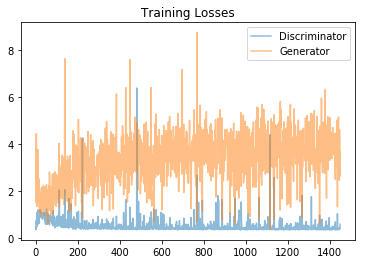

In [24]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [25]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    zipped = list(zip(axes.flatten(), samples[epoch]))
    for ax, img in zipped:
            img = img.detach().cpu().numpy()
            img = np.transpose(img, (1, 2, 0))
            img = ((img + 1)*255 / (2)).astype(np.uint8)
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
            im = ax.imshow(img.reshape((32,32,3)))

In [26]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

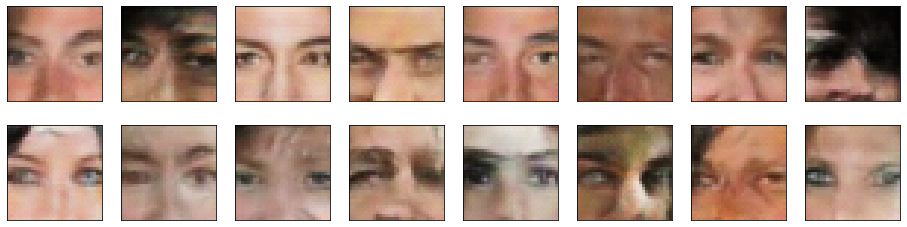

In [27]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:**
I noticed that my sample is biased, which is the result of the training dataset being biased. The training dataset is biased in at least the following ways: 

- Race
- Gender indentity 
- Digital divide status
- Economic status, such as class
- Apperance
- Income 
- Age
- Disabilty status 
- Work / military experience 
- National origin

My sample appears to be mostly pale-skinned people. My sample suggests a theme of not being able to afford acceptable healthcare

The model could be improved by: 

- Increasing the diversity of the training data, such as through race and through disabilty status
- Decreasing the variance of the training data, such as through if the subject if wearing sunglasses
- Increasing the model size
- Improving the optimazation stratgery

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.